In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import re
import os

# Hint

The data across first men's team, women's team, all academy

# Objectivo
1. Which player belongs to which team
   - Anyone has been promoted from youth to senoir team? Or back to the reserve team? Compare the physical profile when he was in youth to the first team?
   - Anyone's position has been changed during the last 2 season?
2. Periodization of training
   - Daily report by team
3. Injury
   - Any player disappeared and back after high load?
   - How did the player rehab?

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 2000

In [3]:
df = pd.read_csv("anonymous.csv")

In [44]:
# transfer km/h to m/s for max velocity
df["maximum_velocity_km_h"] = df["maximum_velocity_km_h"]/3.6


In [45]:
# Rename columns for reporting purpose
df.columns = ['Date', 'Player', 'Position', 'Team Name', 'Duration',
       'Total Distance(m)', 'Total Player Load', 'Acc 2m/s2 Total Effort',
       'Acc 3m/s2 Total Effort', 'Dec 2m/s2 Total Effort',
       'Dec 3m/s2 Total Effort', 'High Intensity Distance(m)',
       'Sprint Distance(m)', 'Maximum Velocity(m/s)', 'IMA COD(left)',
       'IMA COD(right)']

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [49]:
# Function to determine the season
def get_season(date):
    for season, (start_date, end_date) in seasons.items():
        if start_date <= date.strftime('%Y-%m-%d') <= end_date:
            return season
    return None


In [51]:
seasons = {
    "2021/22": ('2021-07-01', '2022-06-30'),
    "2022/23": ('2022-07-01', '2023-06-30')
}

In [52]:
# Apply the function to create the 'Season' column
df['Season'] = df['Date'].apply(get_season)

In [53]:
df.head()

,Date,Player,Position,Team Name,Duration,Total Distance(m),Total Player Load,Acc 2m/s2 Total Effort,Acc 3m/s2 Total Effort,Dec 2m/s2 Total Effort,Dec 3m/s2 Total Effort,High Intensity Distance(m),Sprint Distance(m),Maximum Velocity(m/s),IMA COD(left),IMA COD(right),Season
0,2021-07-01,Player1,Central Midfielder,Team1,102,5162.0,491.0,3,0,7,2,96.7,0.0,7.138889,50,39,2021/22
1,2021-07-01,Player2,Central Midfielder,Team1,190,4932.9,561.4,14,1,12,3,170.0,0.0,6.944444,43,42,2021/22
2,2021-07-06,Player3,Winger,Team2,66,5628.6,626.4,18,2,11,1,223.8,39.1,8.333333,33,23,2021/22
3,2021-07-06,Player4,Central Midfielder,Team3,55,6239.1,624.9,18,1,9,7,332.4,12.2,8.138889,17,18,2021/22
4,2021-07-06,Player5,Attacker,Team3,55,5440.4,507.1,22,3,14,8,299.6,6.1,8.111111,19,40,2021/22


---

In [39]:
# Define season
date_ranges = {
    "2021/22": ('2021-07-01', '2022-06-30'),
    "2022/23": ('2022-07-01', '2023-06-30'),
    "Overall": ('2021-07-01', '2023-06-30')
}

In [7]:
squads = df.groupby("Team Name")["Player"].apply(set).to_dict()

In [8]:
for key, value in squads.items():
    print(key, len(value))

Team1 91
Team2 45
Team3 41
Team4 23
Team5 61
Team6 39
Team7 43
Team8 7


- Parameter Definition: https://support.catapultsports.com/hc/en-us/articles/360001935876-Vector-Smartwatch-App-Parameters-Definitions. 
- What is IMA: https://support.catapultsports.com/hc/en-us/articles/360000510856-What-is-IMA
- ima_cod_left/right: Inertial Movement Analysis - Change of Direction

In [41]:
def create_sankey(df, date_range, column_name, node_positions=None):
    # Filter DataFrame for the given date range
    start_date, end_date = date_range
    df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
    # Create a list of unique values in the specified column
    nodes = df_filtered[column_name].unique().tolist()
    
    # Initialize the Sankey diagram components
    node_labels = nodes
    links = {'source': [], 'target': [], 'value': []}
    
    # Create the links for the Sankey diagram
    previous_value = {}

    for date, group in df_filtered.groupby('Date'):
        current_value = group.set_index('Player')[column_name].to_dict()

        if previous_value:
            for player, value in current_value.items():
                if player in previous_value and previous_value[player] != value:
                    source_idx = nodes.index(previous_value[player])
                    target_idx = nodes.index(value)
                    links['source'].append(source_idx)
                    links['target'].append(target_idx)
                    links['value'].append(1)

        previous_value = current_value

    # Extract positions for each node, setting default None for unspecified positions
    node_x = [node_positions[value][0] if node_positions and value in node_positions else None for value in node_labels]
    node_y = [node_positions[value][1] if node_positions and value in node_positions else None for value in node_labels]

    # Create the Sankey diagram with specified node positions
    fig = go.Figure(go.Sankey(
        node=dict(
            pad=30,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=node_labels,
            x=node_x,
            y=node_y
        ),
        link=dict(
            source=links['source'],
            target=links['target'],
            value=links['value']
        )
    ))

    fig.update_layout(title_text=f"Player Movements Between {column_name}s ({start_date} to {end_date})", font_size=10)
    return fig

In [42]:
# Specify node positions for specific teams (Team2 and Team4 in this example)
node_positions = {
    'Team1': (None, None),
    'Team2': (None, None),  
    'Team3': (0, 0),
    'Team4': (None, None),
    'Team5': (None, None),
    'Team6': (None, None),
    'Team7': (0.95, 0.8),
    'Team8': (0.7, 0.9),
}

In [43]:
# Create Sankey diagrams for each date range using 'Team Name'
for title, date_range in date_ranges.items():
    fig = create_sankey(df, date_range, 'Team Name', node_positions)
    fig.show()

- Men's team:
Team 1, 2, 3, 4, 5, 6
- Women's team:
Team 7, 8

In [33]:
# Create a list of unique positions
positions = df['Position'].unique().tolist()

# Initialize the Sankey diagram components
node_labels = positions
links = {'source': [], 'target': [], 'value': []}

# Create the links for the Sankey diagram
previous_position = {}

for date, group in df.groupby('Date'):
    current_position = group.set_index('Player')['Position'].to_dict()
    
    if previous_position:
        for player, position in current_position.items():
            if player in previous_position and previous_position[player] != position:
                source_idx = positions.index(previous_position[player])
                target_idx = positions.index(position)
                links['source'].append(source_idx)
                links['target'].append(target_idx)
                links['value'].append(1)
    
    previous_position = current_position

# Specify node positions for specific positions (Position2 and Position4 in this example)
node_positions = {
    'Position1': (None, None),
    'Position2': (0.3, 0.9),  # Specific position for Position2
    'Position3': (None, None),
    'Position4': (0.7, 0.1)   # Specific position for Position4
}

# Extract positions for each node, setting default None for unspecified positions
node_x = [node_positions[position][0] if position in node_positions else None for position in node_labels]
node_y = [node_positions[position][1] if position in node_positions else None for position in node_labels]

# Create the Sankey diagram with specified node positions
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels,
        x=node_x,
        y=node_y
    ),
    link=dict(
        source=links['source'],
        target=links['target'],
        value=links['value']
    )
))

fig.update_layout(title_text="Player Movements Between Positions Over Time", font_size=10)
fig.show()

# Metrics Explore

In [48]:
df.head()

,Date,Player,Position,Team Name,Duration,Total Distance(m),Total Player Load,Acc 2m/s2 Total Effort,Acc 3m/s2 Total Effort,Dec 2m/s2 Total Effort,Dec 3m/s2 Total Effort,High Intensity Distance(m),Sprint Distance(m),Maximum Velocity(m/s),IMA COD(left),IMA COD(right)
0,2021-07-01,Player1,Central Midfielder,Team1,102,5162.0,491.0,3,0,7,2,96.7,0.0,7.138889,50,39
1,2021-07-01,Player2,Central Midfielder,Team1,190,4932.9,561.4,14,1,12,3,170.0,0.0,6.944444,43,42
2,2021-07-06,Player3,Winger,Team2,66,5628.6,626.4,18,2,11,1,223.8,39.1,8.333333,33,23
3,2021-07-06,Player4,Central Midfielder,Team3,55,6239.1,624.9,18,1,9,7,332.4,12.2,8.138889,17,18
4,2021-07-06,Player5,Attacker,Team3,55,5440.4,507.1,22,3,14,8,299.6,6.1,8.111111,19,40


In [54]:
# List of metrics to plot
metrics = ['Duration', 'Total Distance(m)', 'Total Player Load', 'Acc 2m/s2 Total Effort',
           'Acc 3m/s2 Total Effort', 'Dec 2m/s2 Total Effort', 'Dec 3m/s2 Total Effort',
           'High Intensity Distance(m)', 'Sprint Distance(m)', 'Maximum Velocity(m/s)',
           'IMA COD(left)', 'IMA COD(right)']


In [67]:
def plot_distribution(df, metric):
    g = sns.FacetGrid(df, col="Team Name", row="Season", margin_titles=True, sharex=False, sharey=False)
    g.map_dataframe(sns.histplot, x=metric, kde=True, bins=10)
    
    for ax in g.axes.flat:
        if ax.get_title():
            title_text = ax.get_title().split(' = ')
            team = title_text[1]
            season = title_text[0]
            print(team, season)
            data_sub = df[(df['Team Name'] == team) & (df['Season'] == season)][metric]
            if not data_sub.empty:
                mean_val = data_sub.mean()
                median_val = data_sub.median()
                q25, q75 = data_sub.quantile([0.25, 0.75])
                std_val = data_sub.std()
                ax.annotate(f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\n25%: {q25:.2f}\n75%: {q75:.2f}\nStd: {std_val:.2f}',
                            xy=(0.95, 0.5), xycoords='axes fraction', fontsize=8, ha='right', bbox=dict(facecolor='white', alpha=0.5))
    
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Distribution of {metric} by Team and Season')
    plt.show()

UnboundLocalError: cannot access local variable 'team' where it is not associated with a value

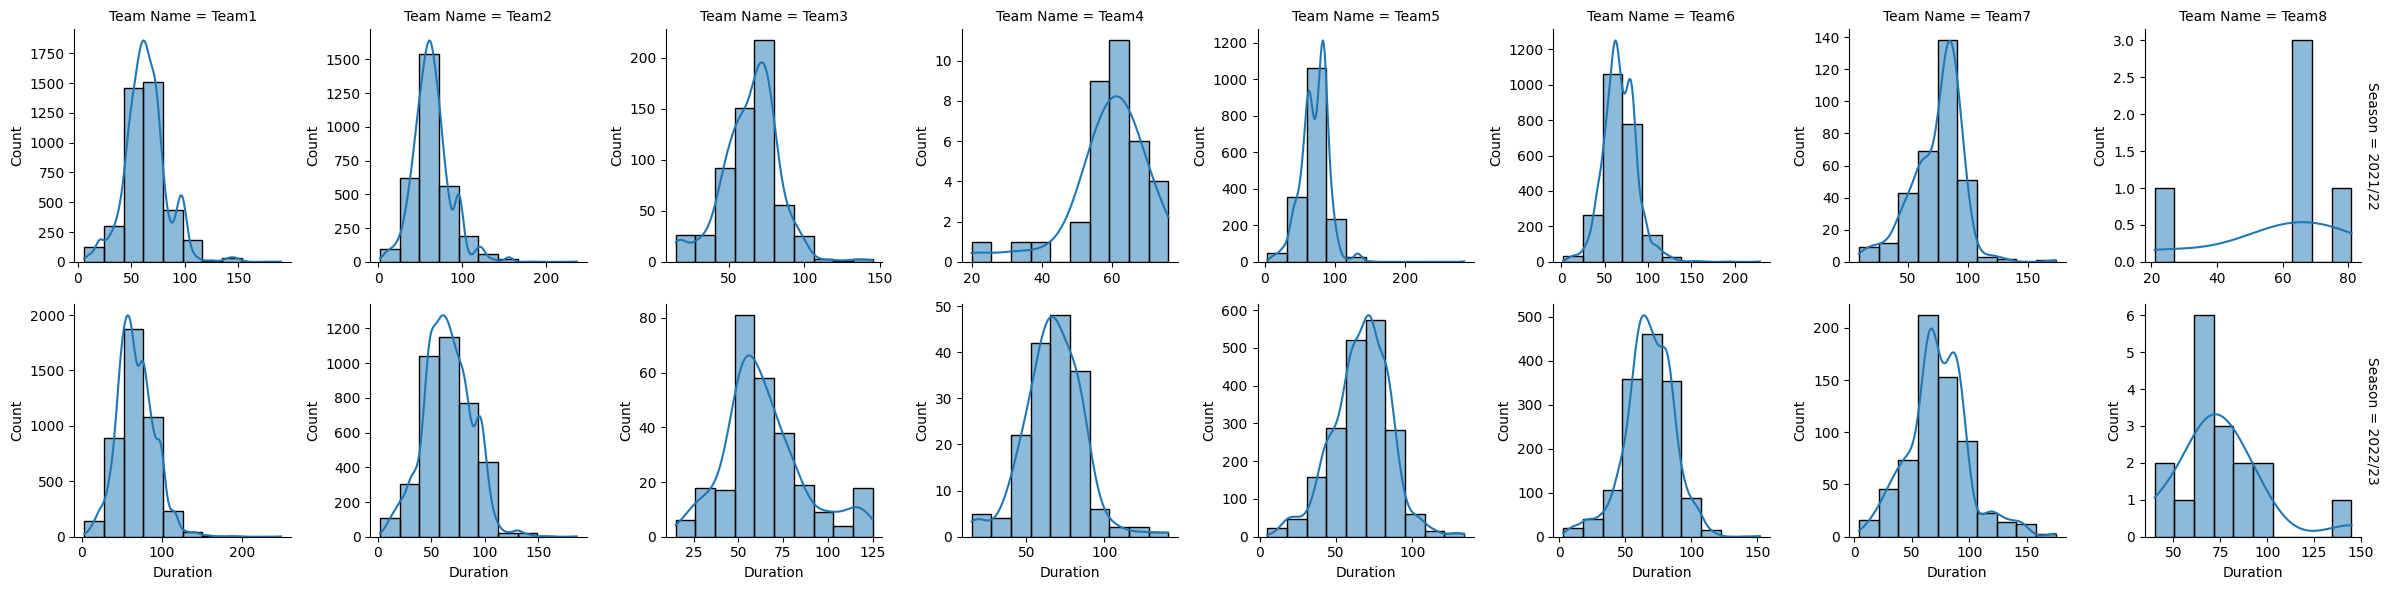

In [68]:
# Plot distributions for each metric
for metric in metrics:
    plot_distribution(df, metric)